<a href="https://colab.research.google.com/github/lalith301/DA-2-Practice-questions-/blob/main/Text_Summarization_usinng_T5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Wed Apr  2 10:07:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   65C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# **Install Required Libraries**

In [2]:
!pip install --quiet pytorch_lightning
!pip install transformers
!pip install --quiet  seaborn
!pip install --quiet  wget
!pip install --upgrade transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 kB 51.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


# **Import Required Libraries**

In [3]:
import torch
from torch.optim import AdamW


In [4]:
import pytorch_lightning as pl
import json
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from termcolor import colored
import textwrap

from transformers import T5ForConditionalGeneration, T5TokenizerFast as T5Tokenizer
from tqdm.auto import tqdm

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

sns.set(style='whitegrid',palette='muted',font_scale=1.2)
rcParams['figure.figsize'] = 16, 6

In [5]:
pl.seed_everything(42)

INFO:lightning_fabric.utilities.seed:Seed set to 42


42

#**Loading the Dataset**

In [6]:
url = 'https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary.csv'

In [7]:
df = pd.read_csv(url,encoding='latin')

In [8]:
df.columns

Index(['author', 'date', 'headlines', 'read_more', 'text', 'ctext'], dtype='object')

In [9]:
df = df[["text","ctext"]]
df.head()

,text,ctext
0,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [10]:
df.columns

Index(['text', 'ctext'], dtype='object')

# **Overview of the Dataset**

In [11]:
df.columns = ["summary", "text"]
df = df.dropna()
df.head()

,summary,text
0,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [12]:
df.shape

(4396, 2)

# **Train Test Split of the Data**

In [13]:
train_df, test_df = train_test_split(df,test_size=0.1)
train_df.shape,test_df.shape

((3956, 2), (440, 2))

# **Tokenize and Process the Data for Model**

In [14]:
class NewsSummaryDataset(Dataset):
  def __init__(
      self,
      data : pd.DataFrame,
      tokennizer : T5Tokenizer,
      text_max_token_len : 512,
      summary_max_token_len : 128
  ):

    self.tokennizer = tokennizer
    self.data = data,
    self.text_max_token_len = text_max_token_len
    self.summary_max_token_len = summary_max_token_len

  def __len__(self):
      return len(self.data)

  def __getitem__(self, index : int):

      data_row = self.data[0].iloc[index]

      text = data_row["text"]

      text_encoding = self.tokennizer(
          text,
          max_length = self.text_max_token_len,
          padding = "max_length",
          truncation = True,
          return_attention_mask = True,
          return_tensors = "pt"
      )

      summary_encoding = self.tokennizer(
          data_row["summary"],
          max_length = self.summary_max_token_len,
          padding = "max_length",
          truncation = True,
          return_attention_mask = True,
          return_tensors = "pt"   # Return PyTorch tensors
      )

      labels = summary_encoding["input_ids"]
      labels[labels==0] = -100

      return dict(
          text = text,
          summary = data_row["summary"],
          text_input_ids = text_encoding["input_ids"].flatten(),
          text_attention_mask = text_encoding["attention_mask"].flatten(),
          labels = labels.flatten(),
          labels_attention_mask = summary_encoding["attention_mask"].flatten()
      )


# **Dataset Preparation Module Using DataLoader**

In [15]:
class NewsSummaryDataModule(pl.LightningDataModule):

    def __init__(
        self,
        train_df : pd.DataFrame,
        test_df : pd.DataFrame,
        tokenizer: T5Tokenizer,
        batch_size : int  = 8,
        text_max_token_len : int = 512,
        summary_max_token_len :int = 128
    ):

        super().__init__()

        self.train_df = train_df
        self.test_df = test_df

        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.text_max_token_len = text_max_token_len
        self.summary_max_token_len = summary_max_token_len

    # LightningModule.setup(stage=None)
    # Called at the beginning of fit (train + validate), validate, test, or predict.

    def setup(self, stage=None):

        self.train_dataset = NewsSummaryDataset(
            self.train_df,
            self.tokenizer,
            self.text_max_token_len,
            self.summary_max_token_len)

        self.test_dataset = NewsSummaryDataset(
            self.test_df,
            self.tokenizer,
            self.text_max_token_len,
            self.summary_max_token_len)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle= True,
            num_workers=2
        )

    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle= False,
            num_workers=2
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle= False,
            num_workers=2
        )

# **Importing the Tokennizer corresponding to T5-Base**

In [16]:
MODEL_NAME = "t5-base"

tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

#**Distribution of Sentence len : News vs Summary**

In [17]:
text_token_counts = []
summary_token_counts = []

for _, row in train_df.iterrows():

    text_token_count = len(tokenizer.encode(row["text"]))
    text_token_counts.append(text_token_count)

    summary_token_count = len(tokenizer.encode(row["summary"]))
    summary_token_counts.append(summary_token_count)


Text(0.5, 1.0, 'Summary text token counts')

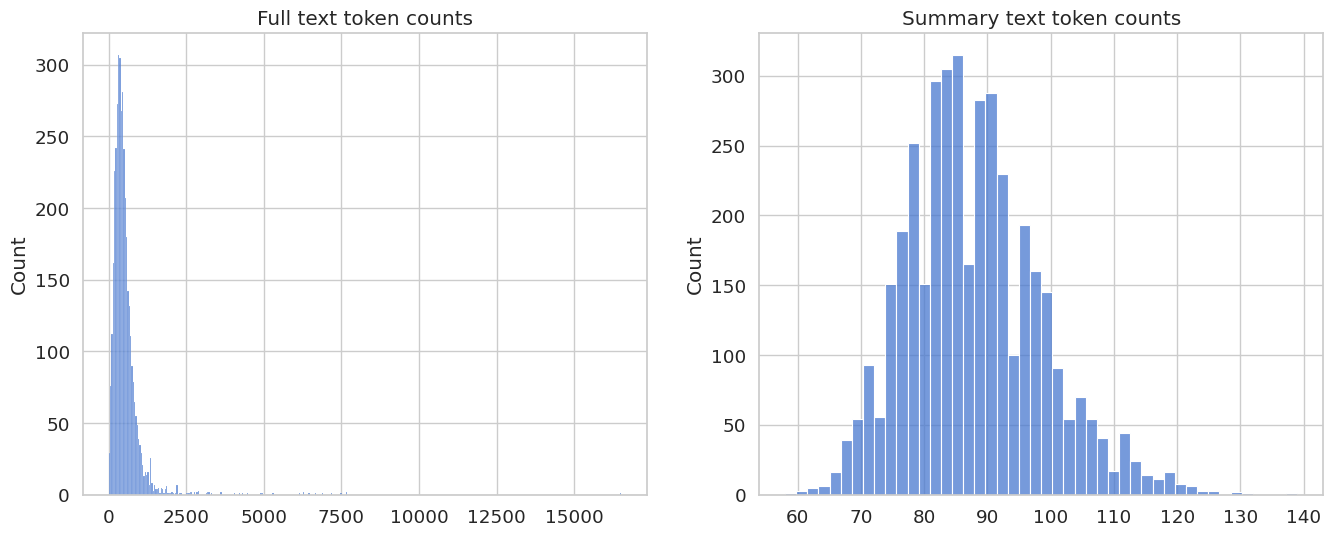

In [18]:
fig, (ax1,ax2) = plt.subplots(1,2)

sns.histplot(text_token_counts,ax=ax1)
ax1.set_title("Full text token counts")

sns.histplot(summary_token_counts,ax=ax2)
ax2.set_title("Summary text token counts")


# **Data Module using DataLoader and Preprocess for training**

In [19]:
N_EPOCHS = 10
BATCH_SIZE = 16

data_module = NewsSummaryDataModule(train_df,test_df,tokenizer,batch_size=BATCH_SIZE)

# **Model Architecture**

In [20]:
class NewsSummaryModel(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME,return_dict=True)

    def forward(self,input_ids,attention_mask,decoder_attention_mask, labels=None):

        output = self.model(
            input_ids,
            attention_mask = attention_mask,
            labels = labels,
            decoder_attention_mask = decoder_attention_mask
        )

        return output.loss, output.logits

    def training_step(self, batch, batch_idx):

        input_ids = batch["text_input_ids"]
        attention_mask = batch["text_attention_mask"]
        labels = batch["labels"]
        labels_attention_mask = batch["labels_attention_mask"]

        loss, outputs = self(
            input_ids = input_ids,
            attention_mask = attention_mask,
            decoder_attention_mask = labels_attention_mask,
            labels = labels
        )

        self.log("train_loss",loss,prog_bar=True,logger=True)

        return loss


    def validation_step(self, batch, batch_idx):

        input_ids = batch["text_input_ids"]
        attention_mask = batch["text_attention_mask"]
        labels = batch["labels"]
        labels_attention_mask = batch["labels_attention_mask"]

        loss, outputs = self(
            input_ids = input_ids,
            attention_mask = attention_mask,
            decoder_attention_mask = labels_attention_mask,
            labels = labels
        )

        self.log("val_loss",loss,prog_bar=True,logger=True)

        return loss

    def test_step(self, batch, batch_idx):

        input_ids = batch["text_input_ids"]
        attention_mask = batch["text_attention_mask"]
        labels = batch["labels"]
        labels_attention_mask = batch["labels_attention_mask"]

        loss, outputs = self(
            input_ids = input_ids,
            attention_mask = attention_mask,
            decoder_attention_mask = labels_attention_mask,
            labels = labels
        )

        self.log("test_loss",loss,prog_bar=True,logger=True)

        return loss


    def configure_optimizers(self):
        return AdamW(self.parameters(),lr = 0.0001)

In [21]:
model = NewsSummaryModel()

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [22]:
##%load_ext tensorboard
##%tensorboard --logdir ./lightning_logs

In [23]:
import torch
torch.cuda.is_available()

True

In [24]:
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min"
)

logger = TensorBoardLogger("lightning_loss",name="news-summary")

import pytorch_lightning as pl

trainer = pl.Trainer(
    logger=logger,
    callbacks=[checkpoint_callback],
    accelerator="gpu",  # Use "cpu" if you don't have a GPU
    devices=1,  # Set to the number of GPUs you want to use
    max_epochs=5  # Adjust as needed
)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


# **Training**

In [25]:
trainer.fit(model,datamodule = data_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                       | Params | Mode
------------------------------------------------------------
0 | model | T5ForConditionalGeneration | 222 M  | eval
------------------------------------------------------------
222 M     Trainable params
0         Non-trainable params
222 M     Total params
891.614   Total estimated model params size (MB)
0         Modules in train mode
541       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 1: 'val_loss' reached 1.19164 (best 1.19164), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 2: 'val_loss' reached 1.17341 (best 1.17341), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 3: 'val_loss' reached 1.16041 (best 1.16041), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 4: 'val_loss' reached 1.15038 (best 1.15038), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 5: 'val_loss' reached 1.14421 (best 1.14421), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


# **Using the Model for Inference**

In [26]:
trained_model = NewsSummaryModel.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

trained_model.freeze()

# **Function to Predict Summary**

In [4]:
import torch

def summarize_text(text):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    text_encoding = tokenizer(
        text,
        max_length=512,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt"
    ).to(device)  # Move encoding to GPU if available

    trained_model.model.to(device)  # Move model to GPU

    generated_ids = trained_model.model.generate(
        input_ids=text_encoding["input_ids"],
        attention_mask=text_encoding["attention_mask"],
        max_length=150,
        num_beams=2,
        repetition_penalty=2.5,
        length_penalty=1.0,
        early_stopping=True
    )

    preds = [tokenizer.decode(gen_id, skip_special_tokens=True, clean_up_tokenization_spaces=True)
             for gen_id in generated_ids]

    return " ".join(preds)

# Example Usage
sample_row = test_df.iloc[0]
text = sample_row["text"]
model_summary = summarize_text(text)
print(model_summary)


NameError: name 'test_df' is not defined

In [ ]:
sample_row = test_df.iloc[0]
text = sample_row["text"]
model_summary = summarize_text(text)

# **Prediction on Test Data**

In [54]:
"""sample_row = test_df.iloc[0]
text = sample_row["text"]
model_summary = summarize_text(text)"""
"""
import torch

def summarize_text(text):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Ensure model is on the same device
    model.to(device)

    # Tokenize input and move to the correct device
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    inputs = {key: value.to(device) for key, value in inputs.items()}  # Move tensors to device

    # Generate summary
    with torch.no_grad():
        summary_ids = model.generate(**inputs)

    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# Test it again
sample_row = test_df.iloc[0]
text = sample_row["text"]
model_summary = summarize_text(text)
print(model_summary)
"""
"""
def summarize_text(text, model, tokenizer, max_length=150):
    # Tokenize the input text
    inputs = tokenizer.encode("summarize: " + text, return_tensors="pt", truncation=True)

    # Generate summary (ensuring the model has a generate method)
    summary_ids = model.generate(inputs, max_length=max_length, min_length=30, length_penalty=2.0, num_beams=4)

    # Decode the output
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Usage
sample_row = test_df.iloc[0]
text = sample_row["text"]
model_summary = summarize_text(text, model, tokenizer)  # Pass model and tokenizer"""
from transformers import T5ForConditionalGeneration, T5Tokenizer

model_name = "t5-small"  # Change to your fine-tuned model path
model = T5ForConditionalGeneration.from_pretrained(model_name)
tokenizer = T5Tokenizer.from_pretrained(model_name)



In [37]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [38]:
model.to(device)  # Move model to GPU/CPU

# If your input text is tokenized using a tokenizer (e.g., for T5 or LSTM)
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)

# Move inputs to the correct device
inputs = {key: value.to(device) for key, value in inputs.items()}

# Run the model
with torch.no_grad():
    output = model.generate(**inputs)

summary = tokenizer.decode(output[0], skip_special_tokens=True)


In [56]:
model_summary = summarize_text(text)


In [3]:
text

NameError: name 'text' is not defined

In [58]:
summarize_text(text)

'Marci Anderson Wahl, 38, of Everett, Washington, was arrested at about 2:15 am yesterday. she was charged with unlawful entry and contempt of court in violation of a stay away order for the White House complex. police said Wahl told them she was there to speak to US President Donald Trump.'

In [59]:
sample_row["summary"]

'A woman, who was arrested twice last week for trying to jump the White House fence, has been arrested for the third time for scaling a fence at the Treasury Building, next to the White House. The woman, who told officers that she wanted to speak to President Donald Trump, has been charged with unlawful entry and contempt of court.'

# **Prediction On Random News**

# *Vedanta's chairman Anil Agarwal earlier this week announced the biggest investment of ₹1.54 lakh crore for setting up the country's first-ever semiconductor chip plant in Gujarat. This led to a strong buying on stock exchanges that drove Vedanta to rise nearly 18% this week. However, on the last trading day of the current week, Vedanta shares pulled back and slipped by at least nearly 9% on BSE after the company said, the semiconductor plant project is not under their ambit but will be undertaken by Volcan Investments.On Thursday, in its regulatory filing, Vedanta said, " we reiterate that the proposed business of manufacturing semiconductors is not under Vedanta and we understand that it will be undertaken by the ultimate holding company of Vedanta, Volcan Investments."This week, in a statement, Vedanta said the company signed two Memorandum of Understanding (MoUs) with the Gujarat government to set up a semiconductor fab unit, a display fab unit, and a semiconductor assembling and testing unit in the Ahmedabad district of the state.*

In [60]:
text = "Vedanta's chairman Anil Agarwal earlier this week announced the biggest investment of ₹1.54 lakh crore for setting up the country's first-ever semiconductor chip plant in Gujarat. This led to a strong buying on stock exchanges that drove Vedanta to rise nearly 18% this week. However, on the last trading day of the current week, Vedanta shares pulled back and slipped by at least nearly 9% on BSE after the company said, the semiconductor plant project is not under their ambit but will be undertaken by Volcan Investments.On Thursday, in its regulatory filing, Vedanta said, we reiterate that the proposed business of manufacturing semiconductors is not under Vedanta and we understand that it will be undertaken by the ultimate holding company of Vedanta, Volcan Investments.This week, in a statement, Vedanta said the company signed two Memorandum of Understanding (MoUs) with the Gujarat government to set up a semiconductor fab unit, a display fab unit, and a semiconductor assembling and testing unit in the Ahmedabad district of the state."

In [62]:
summarize_text(text)

"Vedanta's chairman Anil Agarwal earlier this week announced the biggest investment of 1.54 lakh crore for setting up the country's first-ever semiconductor chip plant in Gujarat. This led to a strong buying on stock exchanges that drove Vedanta to rise nearly 18% this week. However, on the last trading day of the current week, Vedanta shares pulled back and slipped by at least nearly 9% on BSE."

In [65]:
text="Artificial intelligence (AI) is intelligence demonstrated by machines, in contrast to the natural intelligence displayed by humans and animals. Leading AI textbooks define the field as the study of 'intelligent agents': any device that perceives its environment and takes actions that maximize its chance of successfully achieving its goals."

text="Artificial intelligence (AI) is intelligence demonstrated by machines, in contrast to the natural intelligence displayed by humans and animals. Leading AI textbooks define the field as the study of 'intelligent agents': any device that perceives its environment and takes actions that maximize its chance of successfully achieving its goals."

In [66]:
summarize_text(text)

"Artificial intelligence (AI) is the study of 'intelligent agents': any device that perceives its environment and takes actions that maximize its chance of successfully achieving its goals."

In [67]:
!pip install --quiet pytorch_lightning transformers nltk torchtext keras tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.9 MB/s eta 0:00:00


In [68]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
import nltk
nltk.download('punkt')

# Load Dataset
url = 'https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary.csv'
df = pd.read_csv(url, encoding='latin')

# Keep only necessary columns
df = df[['text', 'ctext']]
df.columns = ['summary', 'text']
df = df.dropna()

# Train-Test Split
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [73]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
!pip install --upgrade --force-reinstall nltk
import nltk
nltk.download('punkt')


  Using cached nltk-3.9.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached click-8.1.8-py3-none-any.whl.metadata (2.3 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached regex-2024.11.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (40 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached nltk-3.9.1-py3-none-any.whl (1.5 MB)
Using cached regex-2024.11.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (792 kB)
Using cached click-8.1.8-py3-none-any.whl (98 kB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.67.1
    Uninstalling tqdm-4.67.1:
      Successfully uninstalled tqdm-4.67.1
  Attempting uninstall: regex
    Found existing installation: regex 2024.11.6
    Uninstalling regex-2024.11.6:
      Successfully uninstalled regex-2024.11.6
  Attempting uninstall: joblib
    Found

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
import nltk
import os

nltk_data_path = "/usr/local/nltk_data"
os.makedirs(nltk_data_path, exist_ok=True)
nltk.data.path.append(nltk_data_path)

nltk.download('punkt', download_dir=nltk_data_path)


[nltk_data] Downloading package punkt to /usr/local/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [9]:
import nltk.data
nltk.data.find('tokenizers/punkt')
print("Punkt tokenizer is available!")


Punkt tokenizer is available!


In [18]:
import nltk
nltk.download('punkt')  # Download the Punkt tokenizer models
from nltk.tokenize import sent_tokenize

# Example usage
text = "Artificial intelligence (AI) is intelligence demonstrated by machines. AI is widely used in various fields."
sentences = sent_tokenize(text)
print(sentences)


['Artificial intelligence (AI) is intelligence demonstrated by machines.', 'AI is widely used in various fields.']


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [14]:
import nltk
print(nltk.data.find('tokenizers/punkt.zip'))  # Check if punkt exists


/root/nltk_data/tokenizers/punkt.zip


In [16]:
import nltk
nltk.download('punkt_tab')
nltk.data.path.append('/root/nltk_data')  # Add the correct directory

from nltk.tokenize import sent_tokenize

# Example usage
text = "Artificial intelligence (AI) is intelligence demonstrated by machines. AI is widely used in various fields."
sentences = sent_tokenize(text)
print(sentences)


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


['Artificial intelligence (AI) is intelligence demonstrated by machines.', 'AI is widely used in various fields.']


In [20]:
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def text_rank_summarize(text, num_sentences=3):
    sentences = sent_tokenize(text)
    if len(sentences) <= num_sentences:
        return text  # Return full text if too short

    vectorizer = TfidfVectorizer()
    sentence_vectors = vectorizer.fit_transform(sentences)

    similarity_matrix = cosine_similarity(sentence_vectors)
    scores = similarity_matrix.sum(axis=1)

    ranked_sentences = [sentences[i] for i in np.argsort(scores)[-num_sentences:]]

    return ' '.join(ranked_sentences)

# Example
sample_text = """The rapid advancements in artificial intelligence (AI) have significantly impacted various industries. AI-powered applications, such as chatbots, virtual assistants, and self-driving cars, have become an integral part of our daily lives. Businesses are leveraging AI to enhance customer experiences, automate tasks, and improve efficiency.
However, concerns regarding data privacy, job displacement, and ethical considerations continue to grow. Experts emphasize the need for strict regulations to ensure AI is used responsibly.
Despite these challenges, researchers are optimistic about AI’s potential to solve complex problems, from climate change to healthcare innovations. The future of AI remains uncertain but promising, with continuous developments expected in the coming years."""
print("TextRank Summary:\n", text_rank_summarize(sample_text))


TextRank Summary:
 Experts emphasize the need for strict regulations to ensure AI is used responsibly. The future of AI remains uncertain but promising, with continuous developments expected in the coming years. Businesses are leveraging AI to enhance customer experiences, automate tasks, and improve efficiency.


In [1]:
!pip install tensorflow numpy pandas nltk


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import nltk

# Download necessary NLTK packages
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import sent_tokenize


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [3]:
# Load dataset
url = 'https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary.csv'
df = pd.read_csv(url, encoding='latin')

# Extract text and summaries
texts = df['text'].astype(str).values  # Ensure all values are strings
summaries = df['headlines'].astype(str).values  # Headlines as summaries


In [4]:
# Tokenize input text
text_tokenizer = Tokenizer()
text_tokenizer.fit_on_texts(texts)
text_vocab_size = len(text_tokenizer.word_index) + 1

# Tokenize summaries
summary_tokenizer = Tokenizer()
summary_tokenizer.fit_on_texts(summaries)
summary_vocab_size = len(summary_tokenizer.word_index) + 1

# Convert text and summary to sequences
text_sequences = text_tokenizer.texts_to_sequences(texts)
summary_sequences = summary_tokenizer.texts_to_sequences(summaries)

# Define max lengths
max_text_len = 200
max_summary_len = 50

# Pad sequences
text_sequences = pad_sequences(text_sequences, maxlen=max_text_len, padding='post')
summary_sequences = pad_sequences(summary_sequences, maxlen=max_summary_len, padding='post')


In [5]:
BATCH_SIZE = 8

# Convert to TensorFlow Dataset
dataset = tf.data.Dataset.from_tensor_slices((text_sequences, summary_sequences))

# Shuffle, batch, and prefetch
dataset = dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Train-validation split (90% train, 10% validation)
train_size = int(0.9 * len(text_sequences))
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)


In [6]:
from tensorflow.keras import Input

embedding_dim = 128
lstm_units = 256

model = Sequential([
    Input(shape=(max_text_len,)),  # Explicitly define input shape
    Embedding(input_dim=text_vocab_size, output_dim=embedding_dim),
    LSTM(lstm_units, return_sequences=True),
    LSTM(lstm_units),
    Dense(128, activation='relu'),
    Dense(summary_vocab_size, activation='softmax')
])

# Compile the model
model.compile(optimizer="adam",
              loss=SparseCategoricalCrossentropy(from_logits=False),  # from_logits=False since we use softmax
              metrics=["accuracy"])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 200, 128)            │       2,722,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 200, 256)            │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9396)                │       1,212,084 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,887,476 (18.64 MB)

 Trainable params: 4,887,476 (18.64 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
summary_sequences = np.expand_dims(summary_sequences, axis=-1)


In [8]:
model.compile(optimizer="adam",
              loss=SparseCategoricalCrossentropy(from_logits=False),
              metrics=["accuracy"])


In [9]:
decoder_input_data = summary_sequences[:, :-1]  # Remove last token
decoder_target_data = summary_sequences[:, 1:]  # Shift left



In [10]:
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])


In [13]:
# Shift target sequences to align with expected output
decoder_input_data = summary_sequences[:, :-1]  # Remove last token
decoder_target_data = summary_sequences[:, 1:]  # Shift left

# Ensure correct shape
decoder_target_data = np.array(decoder_target_data)  # Convert to NumPy array
decoder_target_data = decoder_target_data.reshape(-1, max_summary_len - 1)  # Remove extra dims

# Create TensorFlow Dataset
dataset = tf.data.Dataset.from_tensor_slices((text_sequences, decoder_target_data))
dataset = dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Train-validation split
train_size = int(0.9 * len(text_sequences))
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)


In [14]:
# Compile Model (Fixing the Loss)
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),  # ✅ Fix here
    metrics=["accuracy"]
)


In [1]:
!pip install tensorflow --upgrade



In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
import numpy as np


In [7]:
import pandas as pd

url = 'https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary.csv'
df = pd.read_csv(url, encoding='latin')


# Check dataset columns
print(df.columns)



Index(['author', 'date', 'headlines', 'read_more', 'text', 'ctext'], dtype='object')


In [8]:
df = df[['text', 'headlines']].dropna()  # Select relevant columns & remove NaNs

# Convert text to lowercase (optional)
df['text'] = df['text'].str.lower()
df['headlines'] = df['headlines'].str.lower()

# Remove duplicates
df = df.drop_duplicates()

# Display sample
df.head()


,text,headlines
0,the administration of union territory daman an...,daman & diu revokes mandatory rakshabandhan in...
1,malaika arora slammed an instagram user who tr...,malaika slams user who trolled her for 'divorc...
2,the indira gandhi institute of medical science...,'virgin' now corrected to 'unmarried' in igims...
3,lashkar-e-taiba's kashmir commander abu dujana...,aaj aapne pakad liya: let man dujana before be...
4,hotels in maharashtra will train their staff t...,hotel staff to get training to spot signs of s...


In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenizer for both news text and headlines
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'].tolist() + df['headlines'].tolist())  # Fit on both input & output

vocab_size = len(tokenizer.word_index) + 1  # Add 1 for padding index
max_length_text = 100  # Maximum length of news text
max_length_summary = 20  # Maximum length of summary

# Convert text to sequences
X = tokenizer.texts_to_sequences(df['text'].tolist())
X = pad_sequences(X, maxlen=max_length_text, padding='post')

Y = tokenizer.texts_to_sequences(df['headlines'].tolist())
Y = pad_sequences(Y, maxlen=max_length_summary, padding='post')

# Convert Y to NumPy array
import numpy as np
Y = np.array(Y).reshape(-1, max_length_summary)  # Ensure correct shape


In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Selecting relevant columns
texts = df['text']  # Full articles
summaries = df['headlines']  # Headlines (summaries)

# Initialize Tokenizer
tokenizer = Tokenizer(oov_token="<OOV>")  # Handling out-of-vocab words
tokenizer.fit_on_texts(texts)

# Convert text to sequences
tokenized_texts = tokenizer.texts_to_sequences(texts)
tokenized_summaries = tokenizer.texts_to_sequences(summaries)

# Vocabulary size
vocab_size = len(tokenizer.word_index) + 1  # +1 for padding

# Find max sequence lengths dynamically
max_length_text = max([len(seq) for seq in tokenized_texts])
max_length_summary = max([len(seq) for seq in tokenized_summaries])

print(f"Vocabulary Size: {vocab_size}")
print(f"Max Length (Text): {max_length_text}")
print(f"Max Length (Summary): {max_length_summary}")



Vocabulary Size: 21274
Max Length (Text): 70
Max Length (Summary): 14


In [13]:
# Pad sequences to the max length
padded_texts = pad_sequences(tokenized_texts, maxlen=max_length_text, padding='post', truncating='post')
padded_summaries = pad_sequences(tokenized_summaries, maxlen=max_length_summary, padding='post', truncating='post')

# Check shape
print(f"Padded Text Shape: {padded_texts.shape}")
print(f"Padded Summary Shape: {padded_summaries.shape}")


Padded Text Shape: (4514, 70)
Padded Summary Shape: (4514, 14)


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Define LSTM Model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128),  # Remove input_length
    LSTM(256, return_sequences=True),  # Keep return_sequences=True for stacking LSTMs
    LSTM(256),
    Dense(128, activation='relu'),
    Dense(vocab_size, activation='softmax')
])

# **Build Model Explicitly**
model.build(input_shape=(None, max_length_text))

# Compile Model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model Summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 70, 128)             │       2,723,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 70, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 21274)               │       2,744,346 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,419,866 (24.49 MB)

 Trainable params: 6,419,866 (24.49 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")


X_train shape: (3611, 70)
y_train shape: (50554,)


In [21]:
import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"  # Ensures memory growth


In [25]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Ensure GPU Memory Growth (fix RuntimeError)
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
    except RuntimeError as e:
        print(f"Warning: {e}")

# Load Dataset
import pandas as pd

url = "https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary.csv"
df = pd.read_csv(url, encoding='latin-1')

# Preprocess Dataset
texts = df['text'].astype(str).tolist()   # Convert to string
summaries = df['headlines'].astype(str).tolist()

# Tokenize Text
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(texts + summaries)

# Convert text to sequences
X_sequences = tokenizer.texts_to_sequences(texts)
y_sequences = tokenizer.texts_to_sequences(summaries)

# Define Vocab Size & Max Length
vocab_size = len(tokenizer.word_index) + 1  # Plus 1 for padding
max_length = max(max(len(seq) for seq in X_sequences), max(len(seq) for seq in y_sequences))

# Padding
X_padded = pad_sequences(X_sequences, maxlen=max_length, padding='post')
y_padded = pad_sequences(y_sequences, maxlen=max_length, padding='post')

# Split into Train & Validation
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_padded, y_padded, test_size=0.2, random_state=42)

# Define LSTM Model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length),
    LSTM(256, return_sequences=True, activation='tanh', recurrent_activation='sigmoid'),
    LSTM(256, activation='tanh', recurrent_activation='sigmoid'),
    Dense(128, activation='relu'),
    Dense(vocab_size, activation='softmax')
])

# Compile Model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train Model
history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=32,
    validation_data=(X_val, y_val)
)


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


ValueError: Argument `output` must have rank (ndim) `target.ndim - 1`. Received: target.shape=(None, 70), output.shape=(None, 22217)

In [17]:
from sklearn.model_selection import train_test_split

# Split into training (80%) and validation (20%)
X_train, X_val, y_train, y_val = train_test_split(padded_texts, padded_summaries, test_size=0.2, random_state=42)

# Reshape y_train and y_val to remove extra dimensions
y_train = np.array(y_train).reshape(-1)
y_val = np.array(y_val).reshape(-1)

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=32,
    validation_data=(X_val, y_val)
)



ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 3611
'y' sizes: 50554


In [1]:
!pip install tensorflow numpy pandas nltk


In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import nltk
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
from tensorflow.keras.models import Model


In [5]:
# Load dataset
url = "https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary.csv"
df = pd.read_csv(url, encoding='latin-1')

# Selecting relevant columns
df = df[['headlines', 'text']]

# Cleaning function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\(.*?\)', '', text)
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply preprocessing
df['text'] = df['text'].apply(preprocess_text)
df['headlines'] = df['headlines'].apply(preprocess_text)


In [6]:
# Define hyperparameters
max_text_len = 100
max_summary_len = 20
vocab_size = 10000

# Tokenizer for text
text_tokenizer = Tokenizer(num_words=vocab_size)
text_tokenizer.fit_on_texts(df['text'])
text_sequences = text_tokenizer.texts_to_sequences(df['text'])
text_padded = pad_sequences(text_sequences, maxlen=max_text_len, padding='post')

# Tokenizer for summary
summary_tokenizer = Tokenizer(num_words=vocab_size)
summary_tokenizer.fit_on_texts(df['headlines'])
summary_sequences = summary_tokenizer.texts_to_sequences(df['headlines'])
summary_padded = pad_sequences(summary_sequences, maxlen=max_summary_len, padding='post')


In [7]:
# Encoder
encoder_inputs = Input(shape=(max_text_len,))
encoder_embedding = Embedding(vocab_size, 128, trainable=True)(encoder_inputs)
encoder_lstm = LSTM(256, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)

# Decoder
decoder_inputs = Input(shape=(max_summary_len,))
decoder_embedding = Embedding(vocab_size, 128, trainable=True)(decoder_inputs)
decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=[state_h, state_c])

# Attention Layer
attention = tf.keras.layers.Attention()([decoder_outputs, encoder_outputs])

# Output Layer
decoder_dense = Dense(vocab_size, activation='softmax')
output = decoder_dense(attention)

# Define Model
model = Model([encoder_inputs, decoder_inputs], output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

# Model Summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 100)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 20)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 100, 128)       │      1,280,000 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 20, 128)        │      1,280,000 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 100, 256),     │        394,240 │ embedding[0][0]        │
│                           │ (None, 256), (None,    │                │                        │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 20, 256),      │        394,240 │ embedding_1[0][0],     │
│                           │ (None, 256), (None,    │                │ lstm[0][1], lstm[0][2] │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention (Attention)     │ (None, 20, 256)        │              0 │ lstm_1[0][0],          │
│                           │                        │                │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 20, 10000)      │      2,570,000 │ attention[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 5,918,480 (22.58 MB)

 Trainable params: 5,918,480 (22.58 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
!git clone https://github.com/kukrishna/pointer-generator-pytorch-allennlp.git


Cloning into 'pointer-generator-pytorch-allennlp'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 43 (delta 7), reused 7 (delta 7), pack-reused 27 (from 1)
Receiving objects: 100% (43/43), 438.96 KiB | 21.95 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [11]:
!rm -rf pointer-generator-pytorch-allennlp  # Remove any existing folder
!git clone https://github.com/kukrishna/pointer-generator-pytorch-allennlp.git


Cloning into 'pointer-generator-pytorch-allennlp'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 43 (delta 7), reused 7 (delta 7), pack-reused 27 (from 1)
Receiving objects: 100% (43/43), 438.96 KiB | 17.56 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [12]:
%cd pointer-generator-pytorch-allennlp


/content/pointer-generator-pytorch-allennlp


In [13]:
!pip install -r requirements.txt


ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [14]:
!pip install torch allennlp nltk tqdm


INFO: pip is looking at multiple versions of allennlp to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of allennlp to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 28.9 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Installing build dependencies ... error
error: subprocess-exited-with-error

× pip subprocess to install build dependencies did 

In [15]:
!wget -O model.tar.gz "URL_TO_PRETRAINED_MODEL"
!tar -xvzf model.tar.gz


--2025-04-02 16:05:43--  http://url_to_pretrained_model/
Resolving url_to_pretrained_model (url_to_pretrained_model)... failed: Name or service not known.
wget: unable to resolve host address ‘url_to_pretrained_model’

gzip: stdin: unexpected end of file
tar: Child returned status 1
tar: Error is not recoverable: exiting now


In [16]:
# Load dataset
url = "https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary.csv"
df = pd.read_csv(url, encoding='latin-1')


In [26]:
!pip install allennlp



  Using cached allennlp-2.10.1-py3-none-any.whl.metadata (21 kB)
INFO: pip is looking at multiple versions of allennlp to determine which version is compatible with other requirements. This could take a while.
  Using cached allennlp-2.10.0-py3-none-any.whl.metadata (20 kB)
  Using cached allennlp-2.9.3-py3-none-any.whl.metadata (19 kB)
  Using cached allennlp-2.9.2-py3-none-any.whl.metadata (19 kB)
  Using cached allennlp-2.9.1-py3-none-any.whl.metadata (19 kB)
  Using cached allennlp-2.9.0-py3-none-any.whl.metadata (18 kB)
  Using cached allennlp-2.8.0-py3-none-any.whl.metadata (17 kB)
  Using cached allennlp-2.7.0-py3-none-any.whl.metadata (17 kB)
INFO: pip is still looking at multiple versions of allennlp to determine which version is compatible with other requirements. This could take a while.
  Using cached allennlp-2.6.0-py3-none-any.whl.metadata (17 kB)
  Using cached allennlp-2.5.0-py3-none-any.whl.metadata (17 kB)
  Using cached allennlp-2.4.0-py3-none-any.whl.metadata (17 kB

In [22]:
!pip install allennlp==2.10.1 allennlp-models==2.10.1


  Using cached allennlp-2.10.1-py3-none-any.whl.metadata (21 kB)
  Using cached allennlp_models-2.10.1-py3-none-any.whl.metadata (23 kB)
INFO: pip is looking at multiple versions of allennlp to determine which version is compatible with other requirements. This could take a while.
ERROR: Ignored the following versions that require a different python version: 0.2.0 Requires-Python ==3.6
ERROR: Could not find a version that satisfies the requirement torch<1.13.0,>=1.10.0 (from allennlp) (from versions: 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1, 2.1.2, 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.5.0, 2.5.1, 2.6.0)
ERROR: No matching distribution found for torch<1.13.0,>=1.10.0


In [24]:
import allennlp
print("AllenNLP is installed successfully!")


ModuleNotFoundError: No module named 'allennlp'

In [19]:
from allennlp.predictors.predictor import Predictor

predictor = Predictor.from_path("path/to/model.tar.gz")

# Example usage on the first article
input_text = df["text_column"][0]  # Change "text_column" to the actual column name

summary = predictor.predict(input_text)
print("Generated Summary:", summary)


ModuleNotFoundError: No module named 'allennlp'